# Electricity Price Prediction 
> Predicting electric prices for future timestamps using multiple covariates.

- toc: true 
- badges: true
- comments: true
- categories: [machine learning, deep learning, time series,jupyter]
- image: images/chart-preview.png

# Import Data

In [1]:
# Use wget to download the data stored in csv format.
!wget "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Electricity_data_hourly_products.csv"

--2020-11-08 17:28:57--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Electricity_data_hourly_products.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.74.144
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.74.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350029849 (334M) [text/csv]
Saving to: ‘Electricity_data_hourly_products.csv’

Electricity_data_ho 100%[===================>] 333.81M  29.4MB/s    in 12s     

2020-11-08 17:29:10 (27.6 MB/s) - ‘Electricity_data_hourly_products.csv’ saved [350029849/350029849]



In [2]:
# List the directory; the downloaded file should be there. 
!ls -lh

total 334M
-rw-r--r-- 1 root root 334M Sep 30 08:49 Electricity_data_hourly_products.csv
drwxr-xr-x 1 root root 4.0K Oct 28 16:30 sample_data


In [3]:
# Load the data using the pandas library. Use the 1st (0th) column as index
import pandas as pd
df = pd.read_csv('Electricity_data_hourly_products.csv', index_col=0)

# Display the first 5 rows of the data; for a description of the content, see the text below this cell
display(df.head())

# Display basic dataframe info
df.info()

,contractId,qty,px
Datetime,,,
2020-03-01 11:59:13.229,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.1,-1.00
2020-03-01 11:59:46.669,11629792,3.0,-0.99
2020-03-01 11:59:55.065,11629792,3.0,-0.99


<class 'pandas.core.frame.DataFrame'>
Index: 8219996 entries, 2020-03-01 11:59:13.229 to 2020-08-24 20:42:39.432
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   contractId  int64  
 1   qty         float64
 2   px          float64
dtypes: float64(2), int64(1)
memory usage: 250.9+ MB


In [4]:
!pip install seglearn

     |████████████████████████████████| 11.3MB 2.5MB/s 


In [5]:
import seaborn as sns
! pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Visualizations

Partial - Autocorrelation Plots

We take contractID 11762694 as an example for visualization purposes

In [6]:
df1=df[df['contractId'] == 11762694]

**Price Plot**

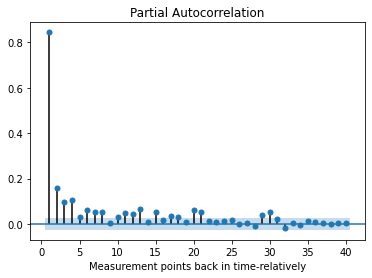

<Figure size 720x720 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt  
import numpy as np  

plot_pacf(df1['px'].values,lags=40,zero=False)
plt.xlabel('Measurement points back in time-relatively')
plt.figure(figsize=(10,10), linewidth=1)
plt.show()

We plot partial autocorrelations to summarize the relationship between px values at a given time in the time series with its obersvations at prior time steps. It appears that the first 7 lags are likely correlated and not simply a statistical fluke. However, the px values do not suggest a strong partial autocorrelation, with approx. 0.2 of the first lag being the maximum value.

 **The plot for the quantity traded**

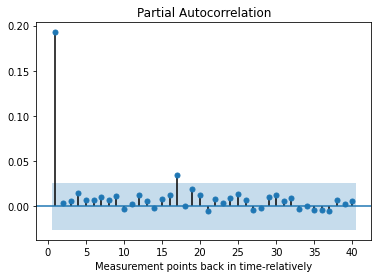

<Figure size 720x720 with 0 Axes>

In [8]:
plot_pacf(df1['qty'].values,lags=40,zero=False)
plt.xlabel('Measurement points back in time-relatively')
plt.figure(figsize=(10,10), linewidth=1)
plt.show()

No strong correlations can be seen from the lags of the quantity qx variable.

In [9]:
# We change to test another ID 11877196

df2=df[df['contractId'] == 11877196]

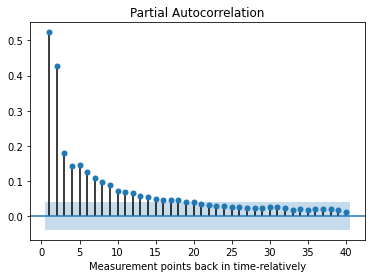

<Figure size 720x720 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt  
import numpy as np  

plot_pacf(df2['px'].values,lags=40,zero=False)
plt.xlabel('Measurement points back in time-relatively')
plt.figure(figsize=(10,10), linewidth=1)
plt.show()

For contractID 11877196 higer correlations of the first lagged variables are 
observable, with its first lag having an autocorrelation of above 0.5

**The Plot for quantity traded**

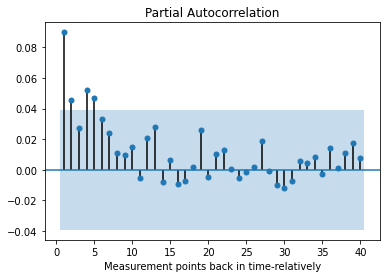

<Figure size 720x720 with 0 Axes>

In [11]:
plot_pacf(df2['qty'].values,lags=40,zero=False)
plt.xlabel('Measurement points back in time-relatively')
plt.figure(figsize=(10,10), linewidth=1)
plt.show()

Here, we see that for the quantity variable of the given contractID, the autocorrlations are statistically relevant. However, the first lag's autocorrelation is still below 0.1 and subsequent autocorrelations are even less.

Generally, in this multi-dimensional time series dataset we see that autocorrelations differ for each contractID.


# Data Preprocessing

In [12]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last
from sklearn.model_selection import train_test_split
import numpy as np
from functools import partial


def bin_ohlcv(df, contractId, binning_size='H'):
    df_cid = df[df.contractId == contractId]
    # resample for a binsize and the ohlc the result; and volume too.
    data = df_cid[['px']].resample(binning_size).ohlc().px
    data['volsum'] = df_cid[['qty']].resample(binning_size).sum()
    data['contractId'] = contractId
    return data

def fillna_close(df):
    for index, row in df.iterrows():
        if not np.isnan(row['close']):
            close = row['close']
        else:
            df.loc[index,'open'] = close
            df.loc[index,'high'] = close
            df.loc[index,'low'] = close
            df.loc[index,'close'] = close
    return df

In [13]:
window_size = 5

In [14]:
df

,contractId,qty,px
Datetime,,,
2020-03-01 11:59:13.229,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.1,-1.00
2020-03-01 11:59:46.669,11629792,3.0,-0.99
2020-03-01 11:59:55.065,11629792,3.0,-0.99
...,...,...,...
2020-08-25 07:47:18.102,11877196,1.6,38.53
2020-08-24 19:56:11.583,11879762,4.5,38.95
2020-08-24 20:42:39.432,11879762,10.5,38.95


The modeling process can be improved by augmenting the information fed into the algorithm. We encode the dataframe by months, days, hours and day of the week to show tha we are dealing with a cyclical time series. This may reveal hidden patterns in the dataset that cannot be revealed with the regular dataframe.

In [15]:
def encode_cyclicals(df_x):
    #"month","day","hour", "cdbw", "dayofweek"
    

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.dayofweek/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.dayofweek/7)
    df_x.drop('dayofweek', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)
    
    return df_x

In [16]:
def preproc(df, window_size, forecast_distance=1):
    df.index=pd.to_datetime(df.index)
    contractIds = df.contractId.unique()
    segmenter = SegmentXYForecast(width=window_size, step=1, y_func=last, forecast=forecast_distance)
    columns = ['contractId','y',]+[ x for x in range(window_size*5)]
    train_df = pd.DataFrame(columns=columns)
    train_rolled_df = []
    label_rolled_df=[]
    error_cids = pd.DataFrame()
    for cid in (contractIds):
        X_train = fillna_close(bin_ohlcv(df, cid))
        X_train['month']=X_train.index.month
        X_train['day']=X_train.index.day
        X_train['dayofweek']=X_train.index.dayofweek
        X_train['hour']=X_train.index.hour
        X_train=encode_cyclicals(X_train)
        if X_train.shape[0] < window_size+forecast_distance:
            error_cids[str(cid)] = X_train.shape[0]
        else:
            y_train = X_train['close']
            X_train = X_train.drop(['contractId','close'], axis=1)
            X_train_rolled, y_train_rolled, _= segmenter.fit_transform([X_train.values],[y_train.values.flatten()])
            train_rolled_df.append(X_train_rolled)
            label_rolled_df.append(y_train_rolled)

            count = 0
            for i in X_train_rolled:
                data = pd.Series(i.flatten())
                train_df = train_df.append(data, ignore_index=True)
                train_df.iloc[-1,0] = str(cid)
                train_df.iloc[-1,1] = y_train_rolled[count]
                count = count+1
    return train_rolled_df,label_rolled_df,train_df, error_cids

In [17]:
df

,contractId,qty,px
Datetime,,,
2020-03-01 11:59:13.229,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.5,-0.99
2020-03-01 11:59:13.243,11629792,0.1,-1.00
2020-03-01 11:59:46.669,11629792,3.0,-0.99
2020-03-01 11:59:55.065,11629792,3.0,-0.99
...,...,...,...
2020-08-25 07:47:18.102,11877196,1.6,38.53
2020-08-24 19:56:11.583,11879762,4.5,38.95
2020-08-24 20:42:39.432,11879762,10.5,38.95


In [18]:
train_rolled_df,label_rolled_df,train_df, error_cids = preproc(df,window_size)

In [19]:
label_rolled_df[0]

array([26.91, 23.7 , 23.69, 21.  , 23.41])

In [20]:
np.concatenate(label_rolled_df,axis=0) # Preprocessing for LSTM

array([26.91, 23.7 , 23.69, ..., 36.9 , 35.  , 38.53])

In [21]:
np.vstack(train_rolled_df).shape

(44548, 5, 12)

In [22]:
train_rolled_df=np.vstack(train_rolled_df)
label_rolled_df=np.concatenate(label_rolled_df,axis=0)

In [23]:
train_df.head()

,contractId,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,11630300,26.91,29.99,30.00,29.99,5.2,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,2.588190e-01,-0.965926,30.02,30.80,28.82,99.9,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,1.224647e-16,-1.000000,20.51,28.82,20.51,279.5,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.258819,-0.965926,25.99,31.40,25.90,469.8,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.500000,-8.660254e-01,30.40,31.19,27.20,451.4,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.707107,-7.071068e-01
1,11630300,23.70,30.02,30.80,28.82,99.9,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,1.224647e-16,-1.000000,20.51,28.82,20.51,279.5,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-2.588190e-01,-0.965926,25.99,31.40,25.90,469.8,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.500000,-0.866025,30.40,31.19,27.20,451.4,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.707107,-7.071068e-01,30.09,30.99,26.54,381.6,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.866025,-5.000000e-01
2,11630300,23.69,20.51,28.82,20.51,279.5,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-2.588190e-01,-0.965926,25.99,31.40,25.90,469.8,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-5.000000e-01,-0.866025,30.40,31.19,27.20,451.4,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.707107,-0.707107,30.09,30.99,26.54,381.6,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.866025,-5.000000e-01,26.60,28.40,18.57,1245.9,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.965926,-2.588190e-01
3,11630300,21.00,25.99,31.40,25.90,469.8,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-5.000000e-01,-0.866025,30.40,31.19,27.20,451.4,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-7.071068e-01,-0.707107,30.09,30.99,26.54,381.6,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.866025,-0.500000,26.60,28.40,18.57,1245.9,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.965926,-2.588190e-01,23.70,26.71,21.01,947.0,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-1.000000,-1.836970e-16
4,11630300,23.41,30.40,31.19,27.20,451.4,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-7.071068e-01,-0.707107,30.09,30.99,26.54,381.6,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-8.660254e-01,-0.500000,26.60,28.40,18.57,1245.9,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.965926,-0.258819,23.70,26.71,21.01,947.0,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-1.000000,-1.836970e-16,23.00,25.60,19.90,1213.6,1.0,6.123234e-17,0.201299,0.97953,-0.781831,0.62349,-0.965926,2.588190e-01


# Data Split

In [24]:
split_size = .1
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['contractId','y'],axis=1),label_rolled_df, test_size=split_size, shuffle=False)
# Creating by splitting from remaning data of train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=split_size, shuffle=False)

mean=np.mean(X_train, axis=0)
std=np.std(X_train, axis=0)

X_train=(X_train-mean)/std
X_valid=(X_valid-mean)/std
X_test=(X_test-mean)/std

Here we process data in two types one flattened for classic supervised machine learning algos and other for deep learning algorithms.


We start with linear regression then gradually try more complex algorithms like random forest and xgboost and record their scores.


# Classic ML Algorithms


In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
%precision 4

'%.4f'

# Dummy Predictor

In [26]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def evaluate_model(model, X_valid, y_valid_true):
    predictions = model.predict(X_valid)
    rms = sqrt(mean_squared_error(y_valid_true, predictions))
    mae = mean_absolute_error(y_valid_true, predictions)
    return rms,mae

In [28]:
dummyrmse,dummymae = evaluate_model(dummy_model, X_test, y_test)

**Linear Regression**

In [29]:
from sklearn.linear_model import LinearRegression
linreg=LinearRegression()
linreg.fit(X_train, y_train)
linregrmse,linregmae = evaluate_model(linreg, X_test, y_test)

In [30]:
from sklearn.ensemble import RandomForestRegressor

N_ESTIMATORS = 50
RANDOM_STATE = 452543634

In [31]:
RF_base_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, max_depth=4, random_state=RANDOM_STATE,n_jobs=-1)
RF_base_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=452543634, verbose=0, warm_start=False)

In [32]:
rfrmse,rfmae = evaluate_model(RF_base_model, X_test, y_test)

**XGBoost**

In [33]:
import xgboost as xgb
# If in trouble, use !pip install xgboost

# XGBoost needs it's custom data format to run quickly
dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
dmatrix_valid = xgb.DMatrix(data=X_valid,label=y_valid)
dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

In [34]:
params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 50}

evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]

num_round = 40 #Can easily overfit, experiment with it!
xg_reg = xgb.train(params, dmatrix_train, num_round, [(dmatrix_valid, 'test'), (dmatrix_train, 'train')])

[17:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:26.1554	train-rmse:21.2551
[1]	test-rmse:18.8739	train-rmse:15.5145
[2]	test-rmse:13.7881	train-rmse:11.6365
[3]	test-rmse:10.4652	train-rmse:9.09538
[4]	test-rmse:8.32127	train-rmse:7.49158
[5]	test-rmse:7.06419	train-rmse:6.51137
[6]	test-rmse:6.3734	train-rmse:5.92332
[7]	test-rmse:6.0122	train-rmse:5.59236
[8]	test-rmse:5.812	train-rmse:5.37985
[9]	test-rmse:5.70591	train-rmse:5.2242
[10]	test-rmse:5.67404	train-rmse:5.12481
[11]	test-rmse:5.63926	train-rmse:5.04321
[12]	test-rmse:5.63908	train-rmse:4.9943
[13]	test-rmse:5.63276	train-rmse:4.95529
[14]	test-rmse:5.64107	train-rmse:4.89816
[15]	test-rmse:5.64481	train-rmse:4.8419
[16]	test-rmse:5.64753	train-rmse:4.82373
[17]	test-rmse:5.65081	train-rmse:4.7665
[18]	test-rmse:5.65059	train-rmse:4.74386
[19]	test-rmse:5.65369	train-rmse:4.72363
[20]	test-rmse:5.65731	train-rmse:4.6661
[21]	test-

In [35]:
xgboostrmse=np.sqrt(1/len(X_test)*np.sum((xg_reg.predict(dmatrix_test)-y_test)**2,axis=0))
xgboostmae=np.sqrt(1/len(X_test)*np.sum(abs(xg_reg.predict(dmatrix_test)-y_test),axis=0))

In [36]:
split_size = .1
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(train_rolled_df,label_rolled_df, test_size=split_size, shuffle=False)
# Creating by splitting from remaning data of train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=split_size, shuffle=False)

mean=np.mean(X_train, axis=0)
std=np.std(X_train, axis=0)

X_train=(X_train-mean)/std
X_valid=(X_valid-mean)/std
X_test=(X_test-mean)/std

In [37]:
X_train.shape

(36083, 5, 12)

In [38]:
X_valid.shape

(4010, 5, 12)

In [39]:
X_test.shape

(4455, 5, 12)

# Deep Learning

For deep learning models we try to be creative and use 1D CNN which is also well suited for time series problems. Then we try a GRU since its much simpler than LSTM which lesser parameters. We add attention to it to make it work better. The models somewhat underfit but still gives us reasonable score with very few parameters.

In [40]:
X_train.shape

(36083, 5, 12)

Sincee Huber loss is a loss function is less sensitive to outliers in data we use it here. Moreover we employ learning rate scheduling as it was used in training resnet.

In [41]:
!pip install attention

In [42]:
from tensorflow.keras.layers import Dense, Dropout, LSTM,GRU,Conv1D,MaxPooling1D,Flatten,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,TimeDistributed,Bidirectional
from tensorflow.keras import backend as be
from tensorflow.keras.optimizers import Adam
from attention import Attention
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

In [43]:
y_train.shape

(36083,)

In [44]:
X_train.shape

(36083, 5, 12)

In [45]:
reduceLR=ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.1,
    patience=5,
    verbose=2,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0000000001
)

In [46]:
X_train.shape

(36083, 5, 12)

In [47]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="same" ,input_shape=(window_size, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,'linear'))
model.summary()
model.compile(loss=Huber(), optimizer=Adam(lr=3e-4),metrics=["mae"])
history = model.fit(X_train, y_train, epochs=40, batch_size=128,shuffle=True, validation_data=(X_valid,y_valid) ,callbacks =[reduceLR])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             2368      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
____________________________________________________

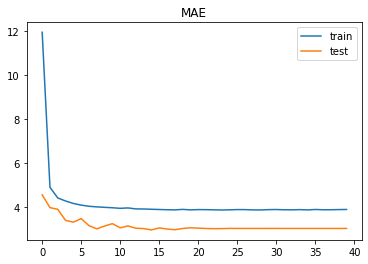

In [48]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.title('MAE')
plt.legend()
plt.show()

In [49]:
cnndeepLearningrmse=np.sqrt(1/len(X_test)*np.sum((model.predict(X_test).reshape(len(X_test),)-y_test)**2,axis=0))
cnndeepLearningmae=1/len(X_test)*np.sum(abs(model.predict(X_test).reshape(len(X_test),)-y_test),axis=0)

In [50]:
be.clear_session()

model2 = Sequential()
model2.add(GRU(30, activation='relu', recurrent_dropout=0.3,return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model2.add(Attention())
model2.add(Dropout(0.3))
model2.add(Dense(1,'linear'))
model2.compile(loss=Huber(), optimizer=Adam(lr=3e-4),metrics=["mae"])
model2.summary()
history2 = model2.fit(X_train, y_train, epochs=30, batch_size=64,shuffle=True, validation_data=(X_valid,y_valid) ,callbacks =[reduceLR])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 30)             3960      
_________________________________________________________________
attention_score_vec (Dense)  (None, 5, 30)             900       
_________________________________________________________________
last_hidden_state (Lambda)   (None, 30)                0         
_________________________________________________________________
attention_score (Dot)        (None, 5)                 0         
_________________________________________________________________
attention_weight (Activation (None, 5)                 0         
_________________________________________________________________
context_vector (Dot)         (None, 30)                0         
_________________________________________________________________
attention_output (Concatenat (None, 60)                0

In [51]:
deepLearningrmse=np.sqrt(1/len(X_test)*np.sum((model2.predict(X_test).reshape(len(X_test),)-y_test)**2,axis=0))
deepLearningmae=1/len(X_test)*np.sum(abs(model2.predict(X_test).reshape(len(X_test),)-y_test),axis=0)

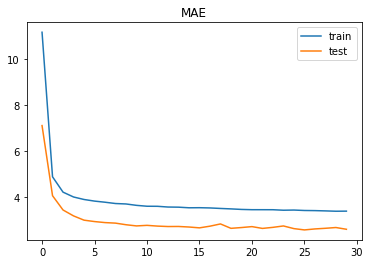

In [52]:
plt.plot(history2.history['mae'], label='train')
plt.plot(history2.history['val_mae'], label='test')
plt.title('MAE')
plt.legend()
plt.show()

In [53]:
data = {'Models':['Dummy Model','Linear Regression', 'Random Forest', 'XGBoost','CNN', 'GRU with Attention'], 'RMSE':[dummyrmse, linregrmse, rfrmse, xgboostrmse,cnndeepLearningrmse,deepLearningrmse], 'MAE':[dummymae, linregmae, rfmae, xgboostmae,cnndeepLearningmae,deepLearningmae]} 
df = pd.DataFrame(data) 
df.index=df.Models
df.drop('Models',axis=1,inplace=True)

Looking at the scores we can somewhat conclude that linear regression works nice but xgboost (great because can be trained incrementally also) and deep learning models also perform really well.

In [54]:
df

,RMSE,MAE
Models,,
Dummy Model,18.179135,14.956636
Linear Regression,8.210400,4.230279
Random Forest,8.317027,3.779954
XGBoost,8.223609,1.920795
CNN,8.535649,3.918862
GRU with Attention,7.565562,3.312582
